# An Example Machine Learning Application in Genomics

**In this notebook you will build a machine learning model to classify genomic sequences into binary (0/1) labels.**

Your task is to 
  1. build a machine learning model using your favorite learning algorithm; 
  2. interpret the feature importance of your trained model. 

Follow the instructions by filling in the blank code blocks; add as many blocks as you need.

Download the simulated genomic sequence file (~610M) and read in the dataset.
md5sum: 81a395f706bd48873a93ef01acc705f7


In [34]:
! if [ ! -f "dataset_Li.pkl" ]; then wget https://master.dl.sourceforge.net/project/summer-research-20/sim_data_1/dataset_Li.pkl ; else echo "Found previous downloaded data."; fi

Found previous downloaded data.


In [35]:
import pickle

with open("dataset_Li.pkl", "rb") as f:
    data = pickle.load(f)

# data is a Python dictionary with keys 'train', 'val', 'test'
print(type(data), data.keys())
# train has N=16000 datapoints for training the model
print("train", data["train"][0].shape, data["train"][1].shape)
# val has N=2000 datapoints for training the model
print("val", data["val"][0].shape, data["val"][1].shape)
# test has N=2000 datapoints for training the model
print("test", data["test"][0].shape, data["test"][1].shape)

<class 'dict'> dict_keys(['train', 'val', 'test'])
train (16000, 1000, 4) (16000, 1)
val (2000, 1000, 4) (2000, 1)
test (2000, 1000, 4) (2000, 1)


In [36]:
# look at train data
print(data["train"][0][0])

[[0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 ...
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]]


In [37]:
# look at train labels
print(data["train"][1][0])

[1]


A note that may help your understanding, but you can also ignore it:

Each datapoint is a 1000x4 matrix. It represents a 1000 bp one-hot encoded DNA sequence with 4 channels: A, C, G, and T. 

An illustration on the conversion from the sequence "CGATAACCGATAT" to a matrix is shown below.
 
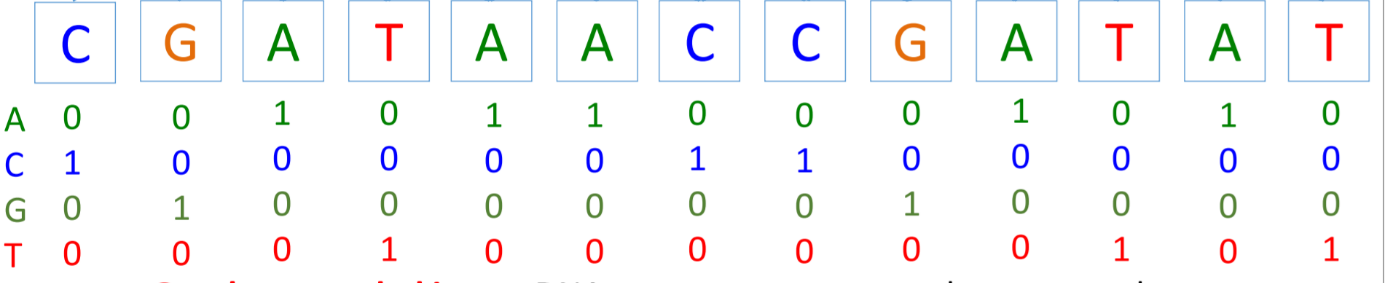

## 1. Build a Machine Learning Model

Use the datapoints under 'train' to train the model, 'val' datapoints for validation, and report the model's performance using hold-out 'test' data.

You can process the input features, and then use whatever machine learning algorithm with the best performance.



In [72]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
# import multinomial naive bayes
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

In [39]:
# Fill in the blank code block 1

# preprocessing data

In [40]:
# convert row to letter
def row_to_letter(row):
    if row[0] == 1:
        return "A"
    elif row[1] == 1:
        return "C"
    elif row[2] == 1:
        return "G"
    elif row[3] == 1:
        return "T"
    else:
        return "N"

# convert matrix
def matrix_to_seq(data):
    seq = ""
    for row in data:
        seq += row_to_letter(row)
    return seq

# convert train data to list of sequences
train_data = []
for seq in data["train"][0]:
    train_data.append(matrix_to_seq(seq))
# convert val data to list of sequences
val_data = []
for seq in data["val"][0]:
    val_data.append(matrix_to_seq(seq))
# convert test data to list of sequences
test_data = []
for seq in data["test"][0]:
    test_data.append(matrix_to_seq(seq))

In [41]:
# convert train labels to list of labels
train_labels = []
for label in data["train"][1]:
    train_labels.append(label[0])
# convert val labels to list of labels
val_labels = []
for label in data["val"][1]:
    val_labels.append(label[0])
# convert test labels to list of labels
test_labels = []
for label in data["test"][1]:
    test_labels.append(label[0])

In [42]:
# convert train data to dataframe
import pandas as pd

train_df = pd.DataFrame({"seq": train_data, "label": train_labels})
# convert val data to dataframe
val_df = pd.DataFrame({"seq": val_data, "label": val_labels})
# convert test data to dataframe
test_df = pd.DataFrame({"seq": test_data, "label": test_labels})

In [43]:
train_df.head()

,seq,label
0,CTCTCCTGTGCGATTCGATCCGTGCAGATGACTATATTAATTATCG...,1
1,TTACGGCACTTCTAAGTTAAAGGGTTAAGGTACGAGAGATTCTTGT...,0
2,TCCGATGGTCTTCCTACAATTGTCGTATTCAAACGACTTCCGAGGT...,0
3,AATAAAGAGACTGTGAACTGCTCTACATACAAGATAATATGTCCGA...,0
4,TACATCCACTTTACTAGCTTCGGAAGACGCATTTTTTACATGGGCT...,1


In [44]:
# preprocessing data using kmers and count vectorizer
# get kmers
def getKmers(sequence, size=6):
    return [sequence[x : x + size].lower() for x in range(len(sequence) - size + 1)]

In [45]:
# apply getKmers to train data
train_df["words"] = train_df.apply(lambda x: getKmers(x["seq"]), axis=1)

In [51]:
train_texts = list(train_df["words"])
for item in range(len(train_texts)):
    train_texts[item] = " ".join(train_texts[item])

val_texts = list(val_df["words"])
for item in range(len(val_texts)):
    val_texts[item] = " ".join(val_texts[item])

test_texts = list(test_df["words"])
for item in range(len(test_texts)):
    test_texts[item] = " ".join(test_texts[item])

In [52]:
train_labels = list(train_df["label"])

In [53]:
# get val_text
val_df["words"] = val_df.apply(lambda x: getKmers(x["seq"]), axis=1)
val_texts = list(val_df["words"])
for item in range(len(val_texts)):
    val_texts[item] = " ".join(val_texts[item])
val_labels = list(val_df["label"])

In [56]:
# get test_text
test_df["words"] = test_df.apply(lambda x: getKmers(x["seq"]), axis=1)
test_texts = list(test_df["words"])
for item in range(len(test_texts)):
    test_texts[item] = " ".join(test_texts[item])
test_labels = list(test_df["label"])

In [57]:
# convert data to CountVectorizer
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(train_texts)
X_val = vectorizer.transform(val_texts)

In [58]:
X_test = vectorizer.transform(test_texts)

In [59]:
# build a multinomial naive bayes model
# and train it on the training data
# store the model in a variable called 'model_nb' and validate it on the validation data
model_nb = MultinomialNB(alpha=0.1)
model_nb.fit(X, train_labels)

MultinomialNB(alpha=0.1)

In [60]:
# evaluate the model on the validation data
# store the accuracy in a variable called 'acc_nb'
acc_nb = model_nb.score(vectorizer.transform(val_texts), val_labels)
print(acc_nb)

0.7455


In [63]:
# classification report
print(
    classification_report(val_labels, model_nb.predict(vectorizer.transform(val_texts)))
)

              precision    recall  f1-score   support

           0       0.74      0.75      0.75      1007
           1       0.75      0.74      0.74       993

    accuracy                           0.75      2000
   macro avg       0.75      0.75      0.75      2000
weighted avg       0.75      0.75      0.75      2000



In [64]:
# evaluate the model on the test data
# store the accuracy in a variable called 'acc_nb_test'
acc_nb_test = model_nb.score(vectorizer.transform(test_texts), test_labels)
print(acc_nb_test)

0.741


## 2. Model Interpretation

Using the model you trained above, interpret the important features. 

Note that the interpretation can be different depending your feature engineering and processing, as well as different modeling strategies from the previous step.

In [67]:
# Fill in the blank code block 2
# interpret the predictions
# store the predictions in a variable called 'pred_nb'
pred_nb = model_nb.predict(vectorizer.transform(test_texts))
acurrcacy = accuracy_score(test_labels, pred_nb)
precision = precision_score(test_labels, pred_nb)
recall = recall_score(test_labels, pred_nb)
f1 = f1_score(test_labels, pred_nb)
print(f"accuracy: {acurrcacy}, precision: {precision}, recall: {recall}, f1: {f1}")

accuracy: 0.741, precision: 0.7610993657505285, recall: 0.7114624505928854, f1: 0.7354443309499488


In [68]:
# interpret important features
# store the important features in a variable called 'important_features'
important_features = np.argsort(model_nb.feature_log_prob_[1])[-10:]
# print the important features
print("Important features: ", important_features)
# print the feature names
print("Feature names: ", np.array(vectorizer.get_feature_names())[important_features])

Important features:  [3900  252   15 3315  972  192  207 3891 3075 3840]
Feature names:  ['ttatta' 'aattta' 'aaaatt' 'tattat' 'attata' 'aataaa' 'aatatt' 'ttatat'
 'taaaat' 'ttaaaa']


/home/codespace/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Visualize your model interpretation results.

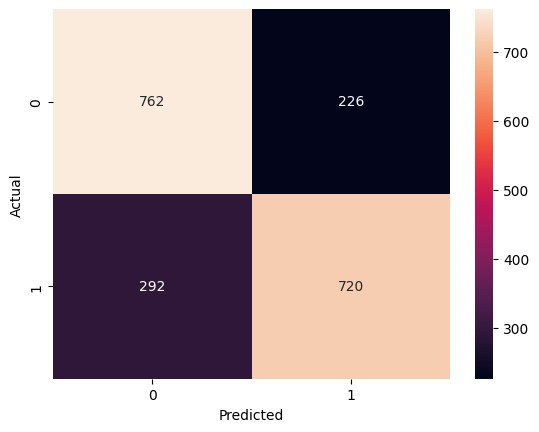

In [70]:
# Fill in the blank code block 3

####
# visuaize model performance
####

# plot the confusion matrix
cm = confusion_matrix(test_labels, pred_nb)
sns.heatmap(cm, annot=True, fmt="d")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

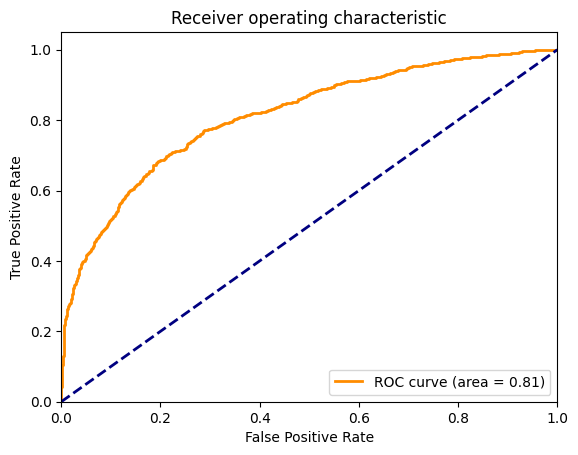

In [71]:
# visualize the ROC curve
fpr, tpr, thresholds = roc_curve(
    test_labels, model_nb.predict_proba(vectorizer.transform(test_texts))[:, 1]
)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color="darkorange", lw=2, label="ROC curve (area = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.legend(loc="lower right")
plt.show()